In [1]:
library(dplyr)
library(ggplot2)
library(gridExtra)
library(tidyr)
# assumes jupyter server launched from root dir of repo
filepath <- paste0(dirname(getwd()), '/')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:
dataset <- 'cces16_ordlogit'
cur_rank <- 4
cur_alpha <- 1
cur_completer <- 'ordlogit'
cur_vmethod <- 'row-norm'

In [3]:
source('eval_util.R')

In [4]:
results <- read_results(dataset)
get_sample_sizes(results)

eval_method completer strategy rank v_method optimality alpha n
1 kfoldcv     bpmf      active   4    row-norm A          1     1
2 kfoldcv     bpmf      random   4    row-norm A          1     1
3 kfoldcv     ordlogit  active   4    row-norm A          1     1
4 kfoldcv     ordlogit  random   4    row-norm A          1     1

In [5]:
strategy_colors <- c('random'='black', 'active'='red', 'sequential'='blue')

In [6]:
question_df <- read.csv(paste0(filepath, 'data/cces/cces16_questions_short.csv'), stringsAsFactors = T)
responses <- read.csv(paste0(filepath, 'data/cces/cces16_ord.csv'), stringsAsFactors = T)
range_by_question <- responses %>% 
    rename(columns = "X") %>%
    gather(key = columns) %>%
    group_by(columns) %>% 
    summarize(max_value = max(value, na.rm = T))

Warning message:
“Column `columns` joining factor and character vector, coercing into character vector”Warning message:
“Column `columns`/`question` joining character vector and factor, coercing into character vector”

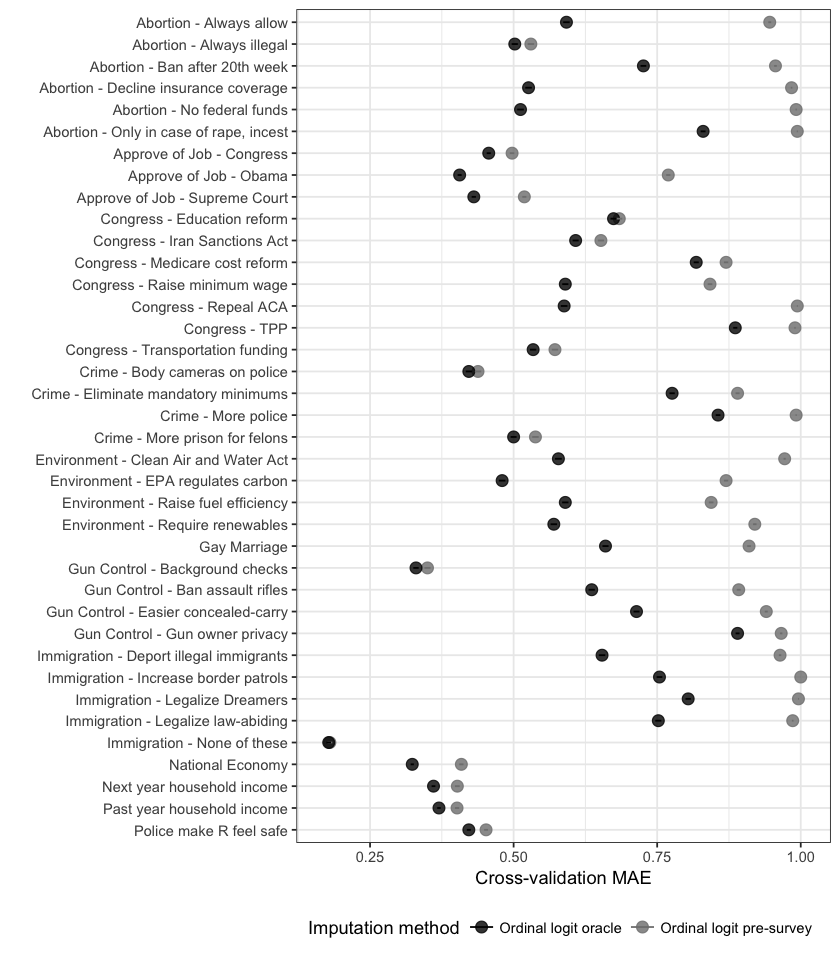

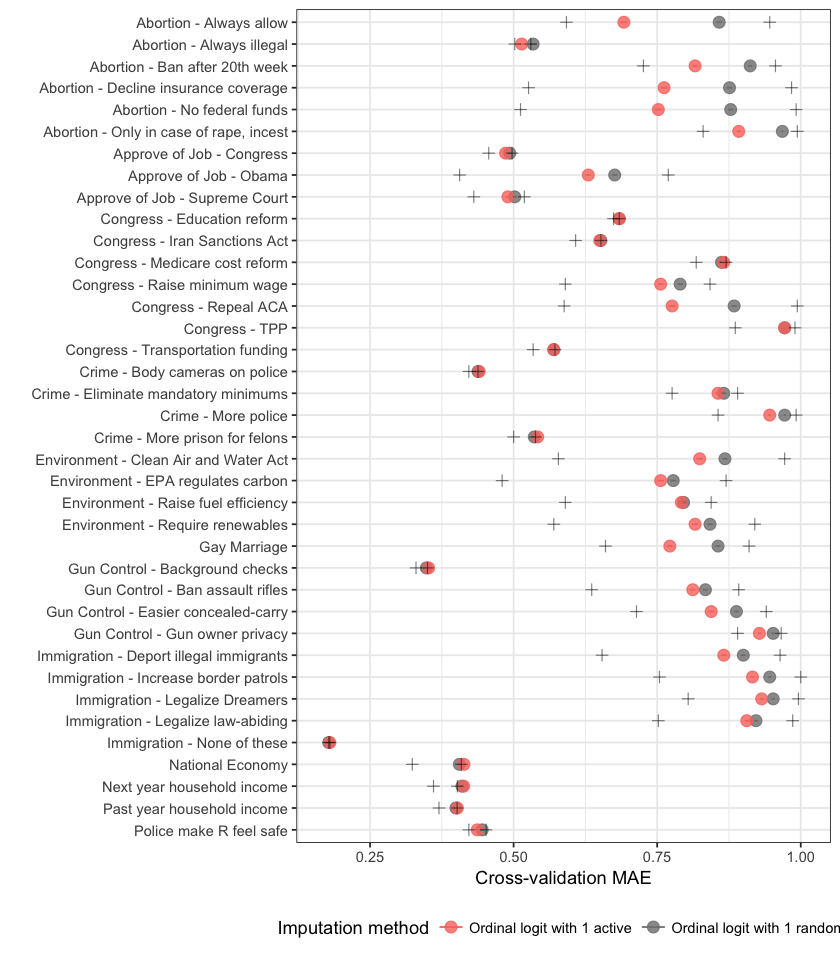

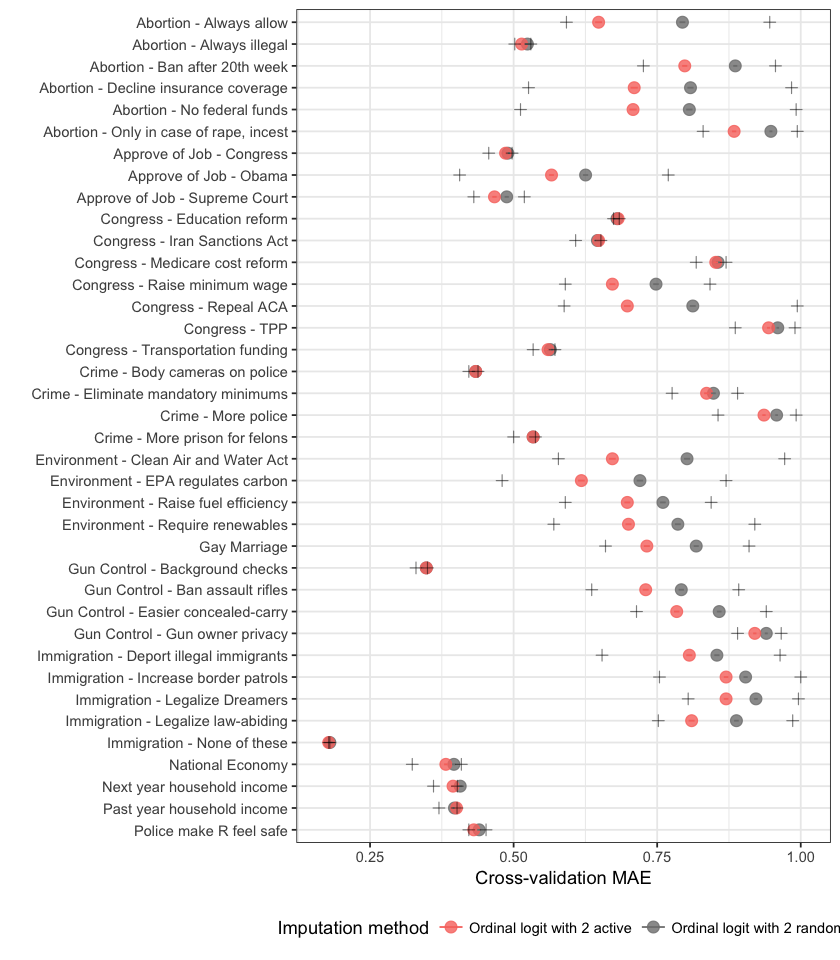

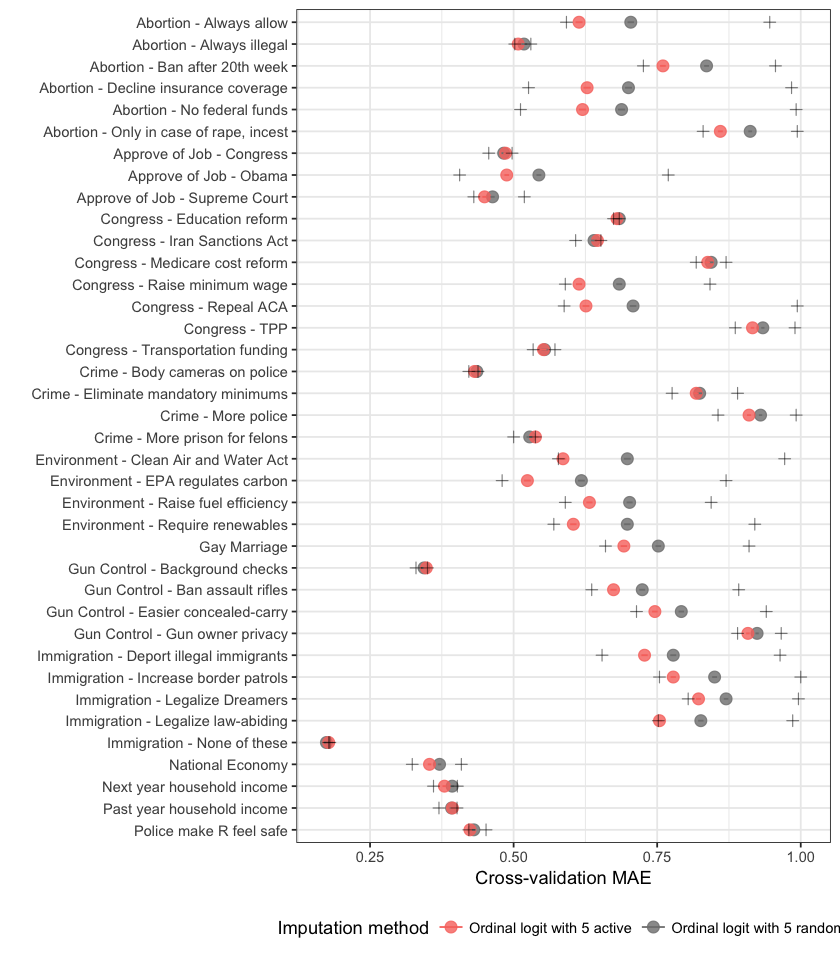

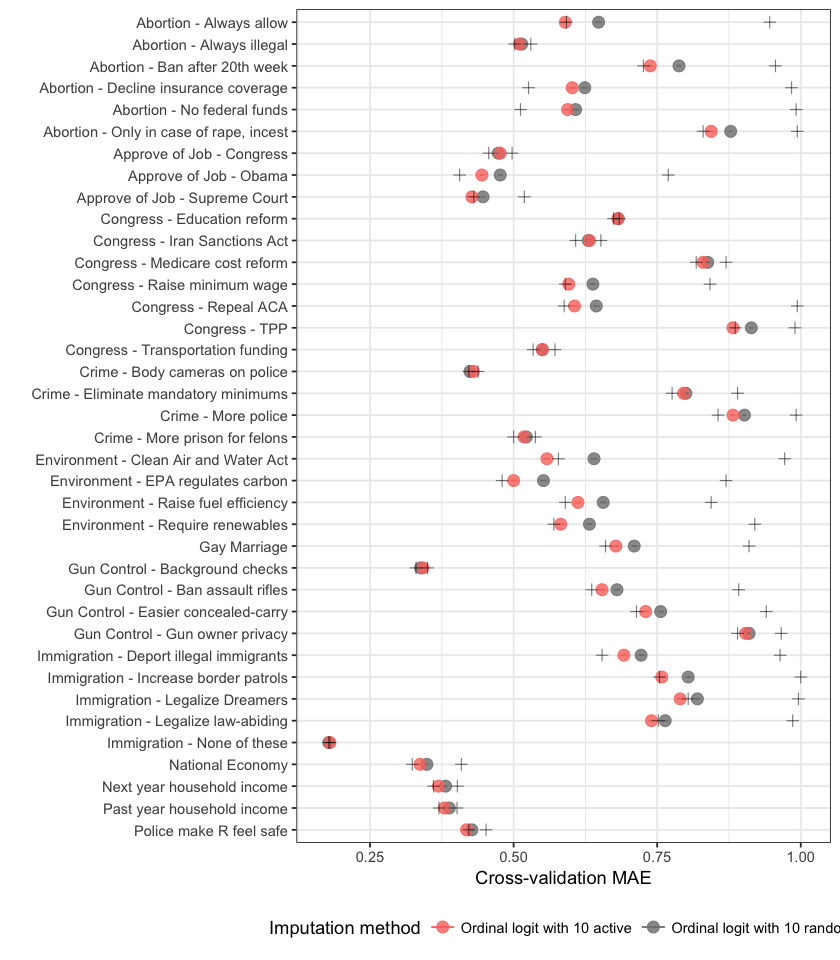

Warning message:
“Column `columns` joining factor and character vector, coercing into character vector”Warning message:
“Column `columns`/`question` joining character vector and factor, coercing into character vector”

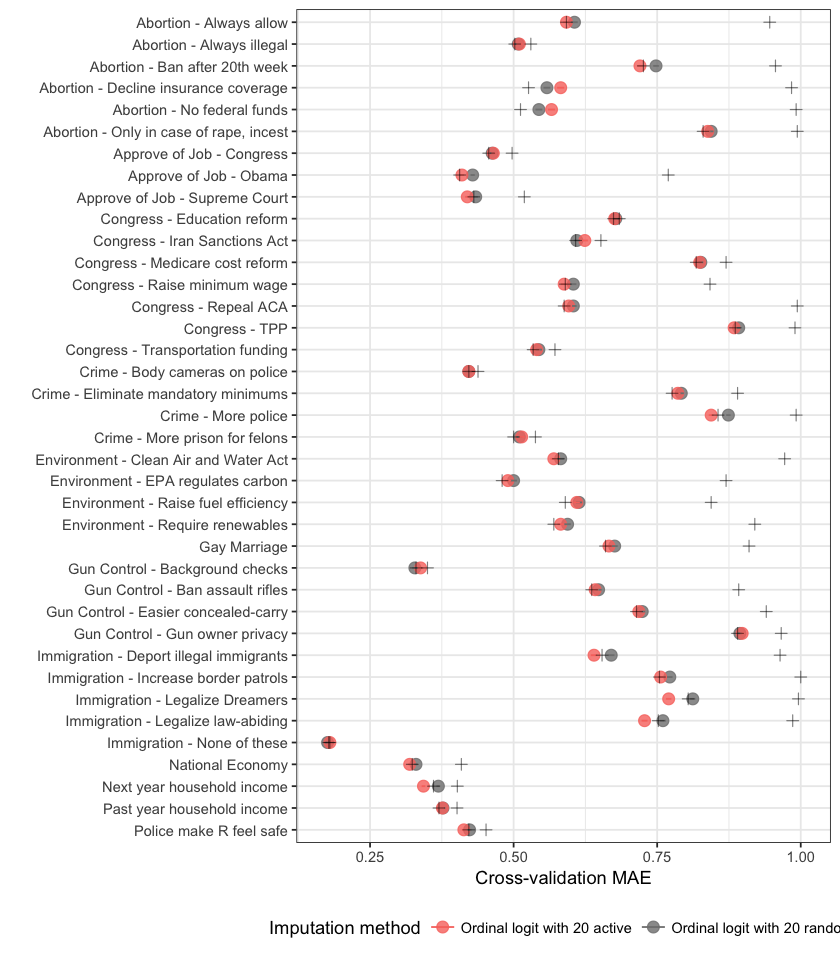

Warning message:
“Removed 2 rows containing missing values (geom_point).”Warning message:
“Removed 2 rows containing missing values (geom_segment).”

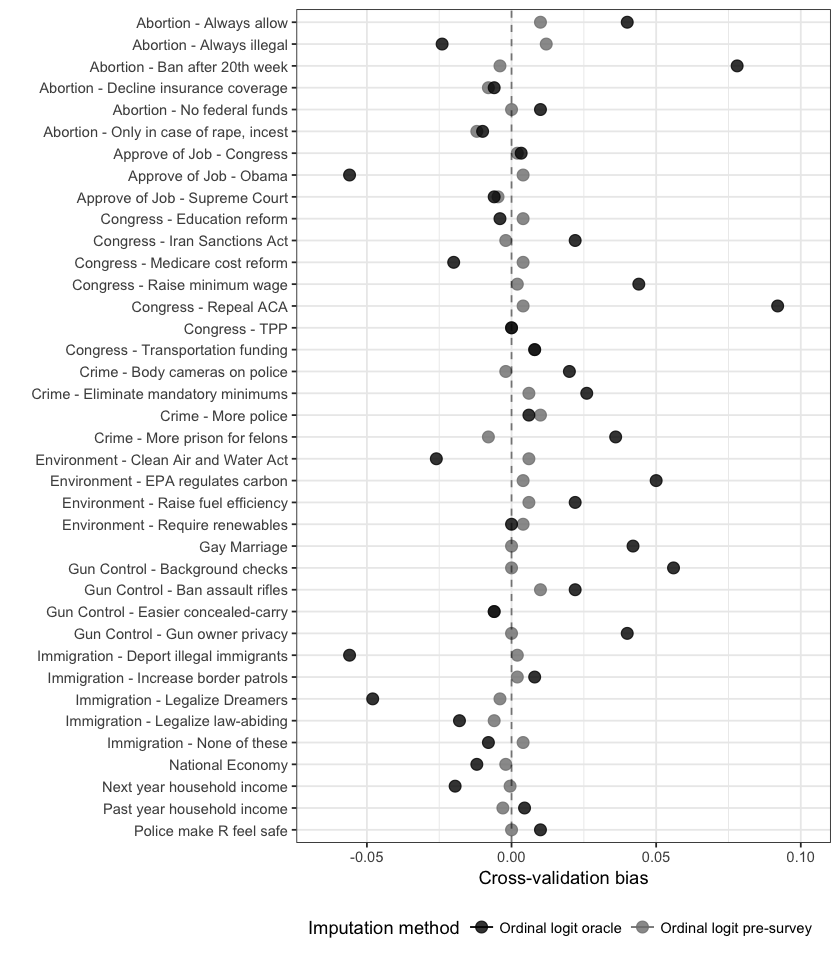

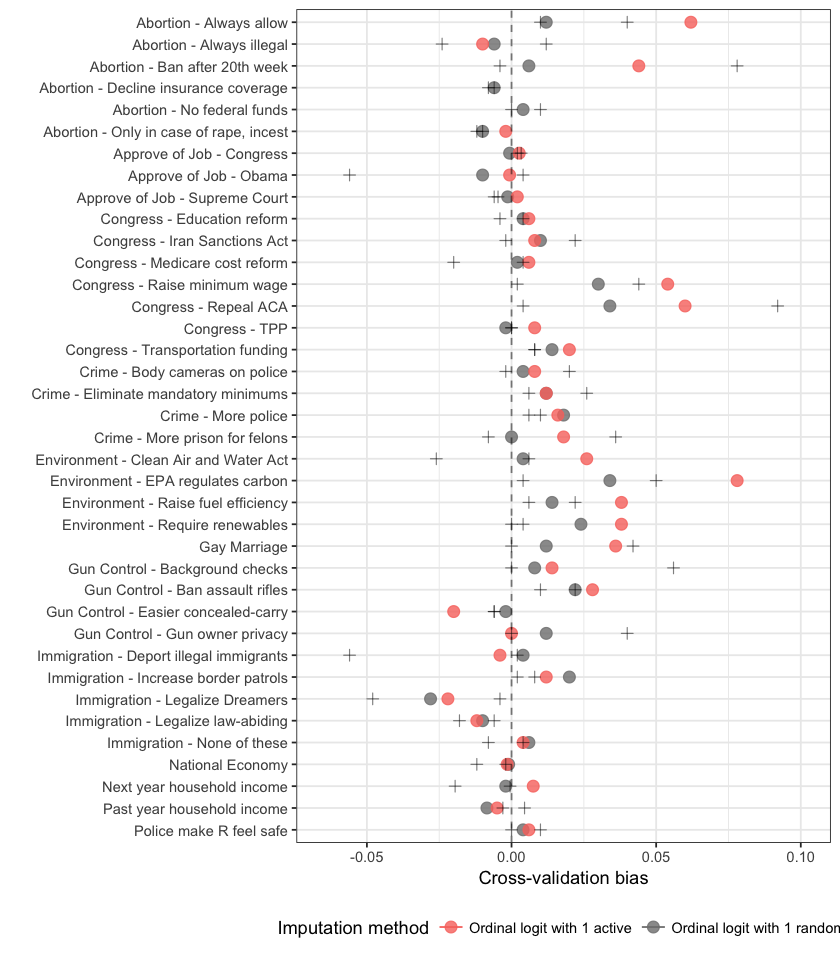

Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_segment).”

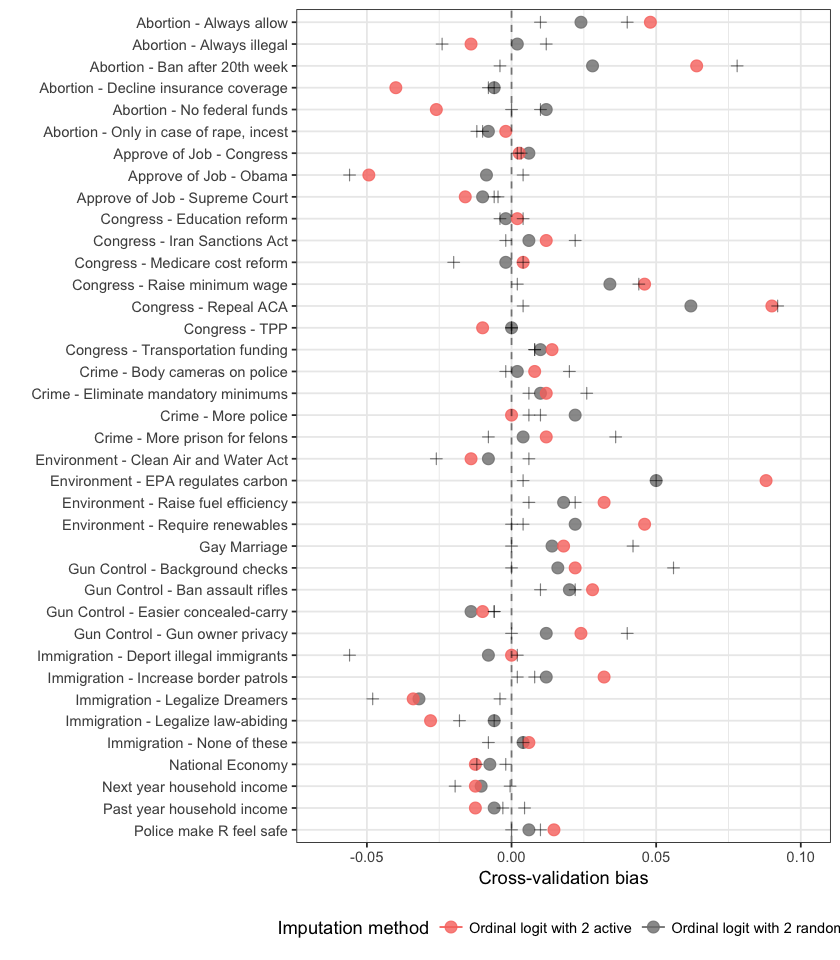

Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_segment).”

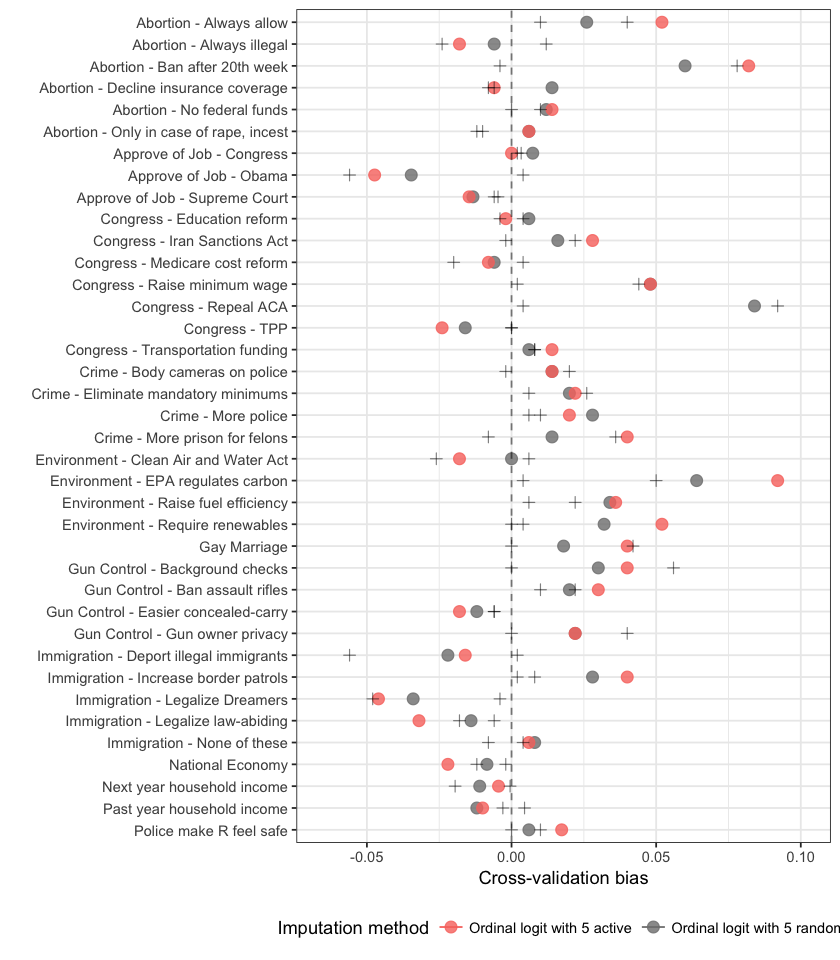

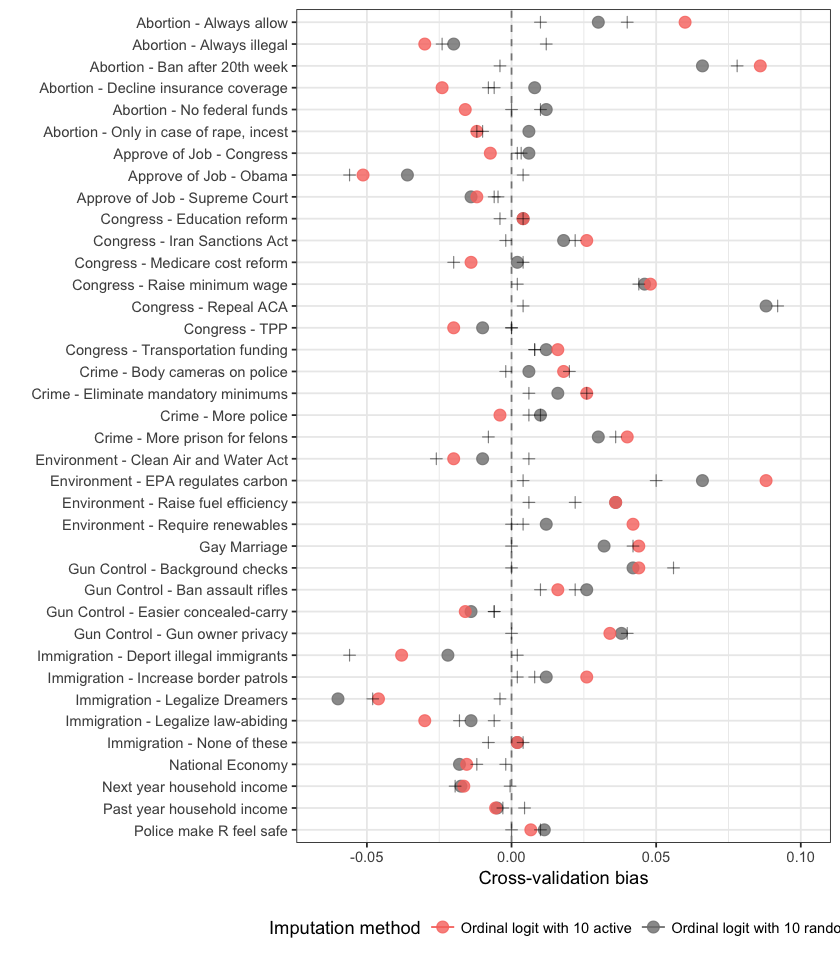

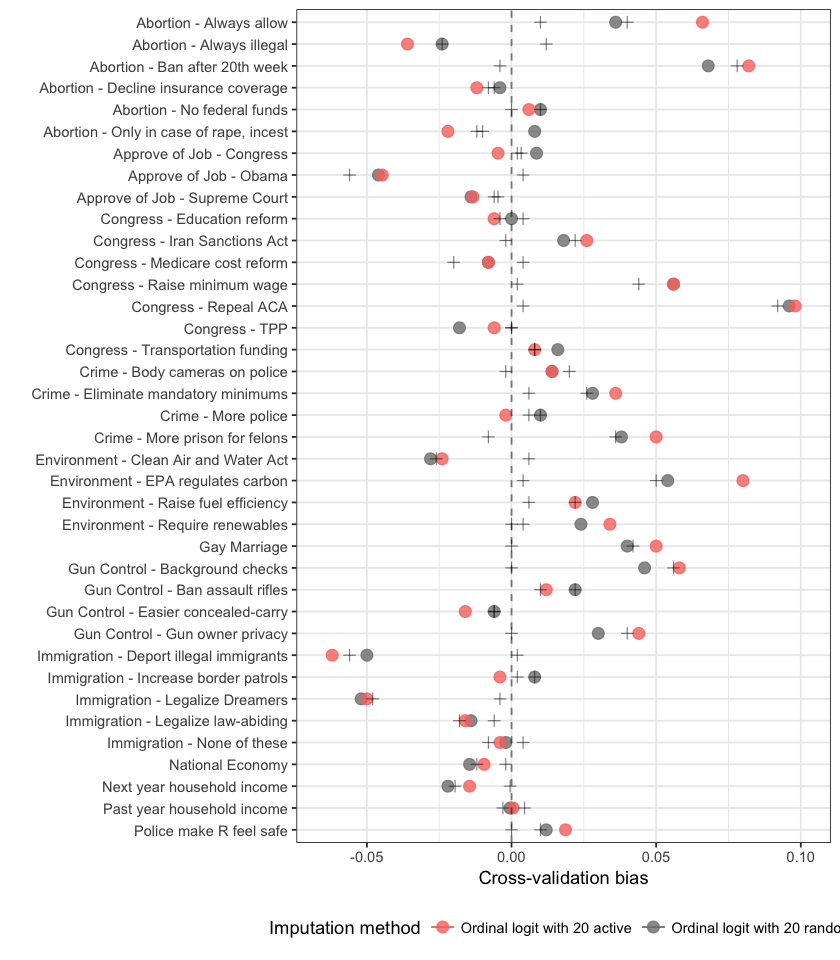

In [7]:
plot_per_question_comparison(y_var='mae', sd_var='sdae', y_var_readable='MAE', question_df=question_df,
                             cur_eval_method = 'kfoldcv', range_by_question = range_by_question)
plot_per_question_comparison(y_var='bias', y_var_readable='bias', question_df=question_df,
                             cur_eval_method = 'kfoldcv', range_by_question = range_by_question)

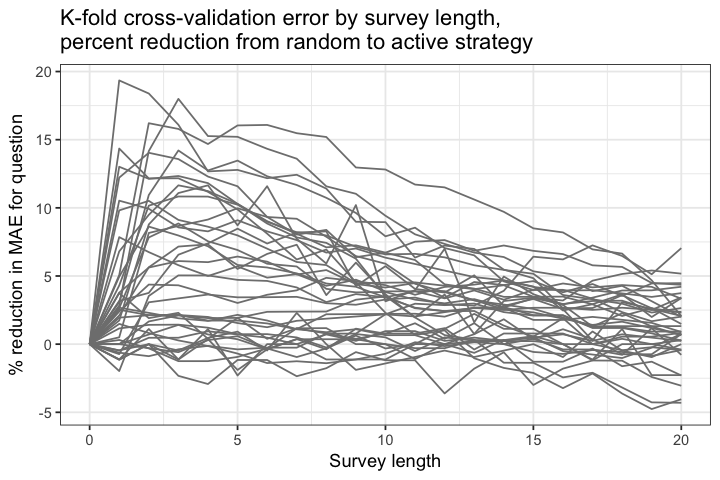

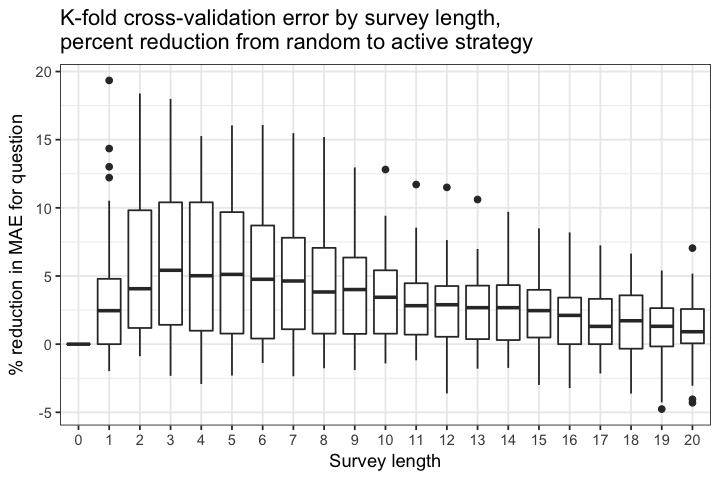

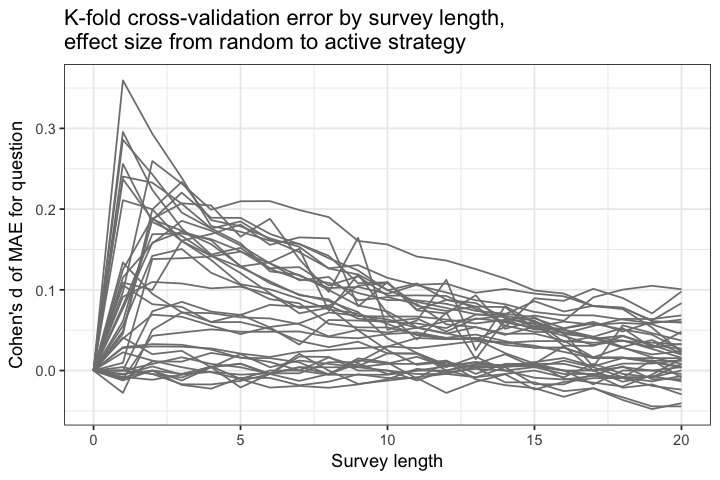

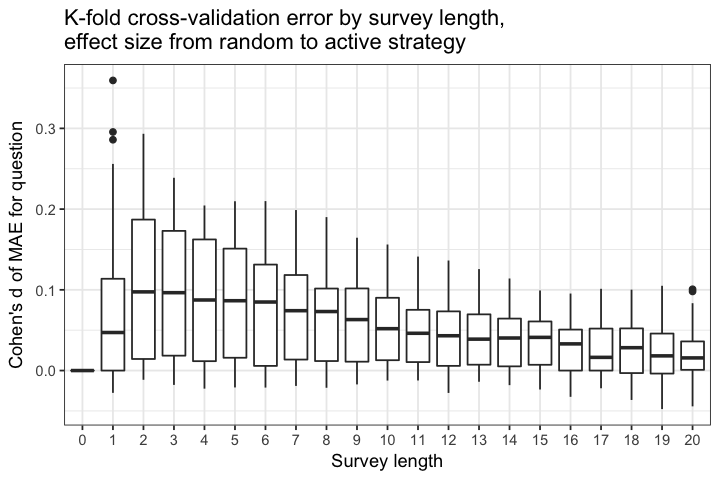

In [8]:
base_method = 'random'
compare_method = 'active'
plot_error_diff(optimality_type='A', base_method=base_method, compare_method=compare_method, y_var='mae', show_max_qnum=20,
                cur_eval_method = 'kfoldcv')
plot_error_diff(optimality_type='A', base_method=base_method, compare_method=compare_method, y_var='mae', show_max_qnum=20, plot_error_diff_fn=plot_error_diff_box,
                cur_eval_method = 'kfoldcv')
plot_effect_size(optimality_type='A', base_method=base_method, compare_method=compare_method, y_var='mae', sd_var='sdae', show_max_qnum=20,
                 cur_eval_method = 'kfoldcv')
plot_effect_size(optimality_type='A', base_method=base_method, compare_method=compare_method, y_var='mae', sd_var='sdae', show_max_qnum=20, plot_error_diff_fn=plot_error_diff_box,
                 cur_eval_method = 'kfoldcv')

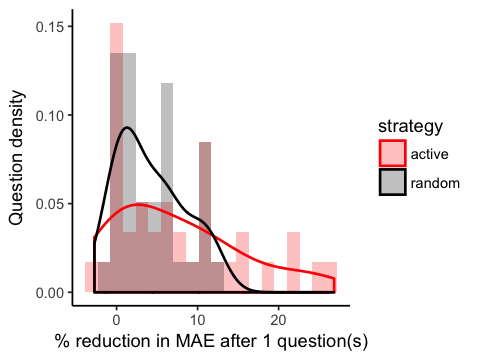

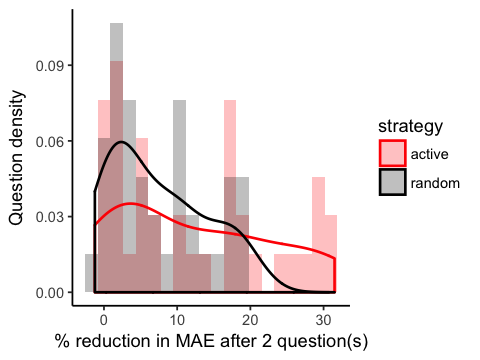

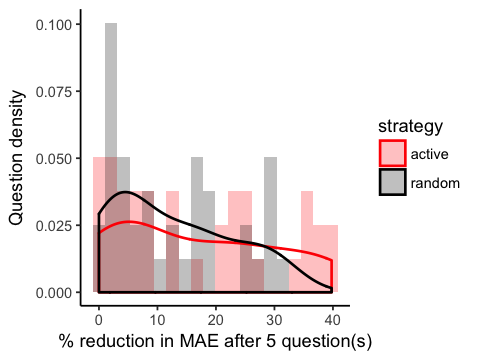

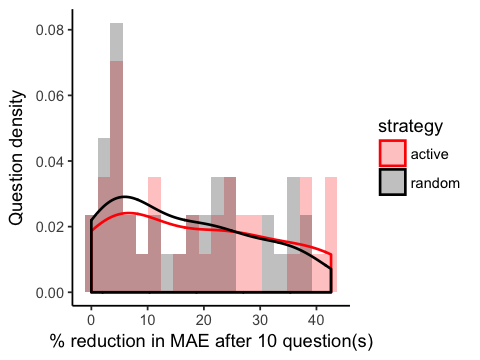

In [9]:
error_reduction_results <- plot_error_reduction_all(y_var='mae', eval_method='kfoldcv')

In [10]:
plot_ordlogit_vs_bpmf <- function(y_var, y_var_readable, sd_var = NULL, question_df = NULL,
    cur_eval_method = 'kfoldcv', range_by_question = NULL) {

    if (!(cur_eval_method %in% c('lococv', 'kfoldcv')))
        stop(paste0("Unsupported eval method ", cur_eval_method))

    cv_readable <- switch(cur_eval_method,
        'lococv' = 'Leave-one-question-out',
        'kfoldcv' = 'Cross-validation')

    cur_results <- results %>% 
        filter(eval_method == cur_eval_method &
               rank == cur_rank & 
               alpha == cur_alpha & 
               v_method == cur_vmethod) %>%
        mutate_(yvar = y_var)
    
    if (is.null(sd_var))
        cur_results <- cur_results %>% mutate(se = 0)
    else
        cur_results <- cur_results %>%
            mutate_(sdvar = sd_var) %>%
            mutate(se = sdvar / sqrt(n))
    
    # standardize error by range of ordinal values per question, if applicable
    if (!is.null(range_by_question)) {
        cur_results <- cur_results %>%
            inner_join(range_by_question, by='columns') %>%
            mutate(yvar = ifelse(completer == 'ordlogit', 2*yvar/max_value, yvar), 
                   se = ifelse(completer == 'ordlogit', 2*se/max_value, se))
    }
    
    if (!is.null(question_df)) {
        cur_results <- cur_results %>% 
            inner_join(question_df, by=c("columns" = "question")) %>%
            mutate(columns = text)
            # mutate(columns = paste0('(', columns, ') ', text))
    }

    pre_survey <- cur_results %>% 
        filter(qnum == 0 & completer == 'bpmf' & strategy == 'random') %>%
        select(columns, yvar, se) %>%
        mutate(label = paste0('BPMF pre-survey'))
    
    oracle <- cur_results %>%
        filter(completer == 'bpmf' & strategy == 'random') %>%
        group_by(columns) %>%
        filter(qnum == max(qnum)) %>%
        ungroup() %>%
        select(columns, yvar, se) %>%
        mutate(label = paste0('BPMF oracle'))
    
    combined_df <- rbind(pre_survey, oracle)
    xmin <- min(combined_df$yvar-2*combined_df$se)-0.01
    xmax <- max(combined_df$yvar+2*combined_df$se)+0.01
    print(pairwise_dotplot_by_question(pre_survey, oracle, y_var_readable, cv_readable, 
        xmin=xmin, xmax=xmax, color_values=c('black', 'gray50')))
    
    for (nq in c(1, 2, 5, 10, 20)) {
        active_bpmf <- cur_results %>% 
            filter(qnum == nq & completer == 'bpmf' & strategy == 'active') %>%
            select(columns, yvar, se) %>%
            mutate(label = paste0('BPMF with ', nq, ' active'))

        active_ordlogit <- cur_results %>% 
            filter(qnum == nq & completer == 'ordlogit' & strategy == 'active') %>%
            select(columns, yvar, se) %>%
            mutate(label = paste0('Ordinal logit with ', nq, ' active'))

        combined_df <- rbind(pre_survey, oracle, active_bpmf, active_ordlogit)
        xmin <- min(combined_df$yvar-2*combined_df$se)-0.01
        xmax <- max(combined_df$yvar+2*combined_df$se)+0.01
        print(pairwise_dotplot_by_question(
            active_bpmf, active_ordlogit, y_var_readable, cv_readable,
            minseries=oracle, maxseries=pre_survey, xmin=xmin, xmax=xmax,
            color_values=c('#f8766d', 'red4')))
    }
}


Warning message:
“Column `columns` joining factor and character vector, coercing into character vector”Warning message:
“Column `columns`/`question` joining character vector and factor, coercing into character vector”

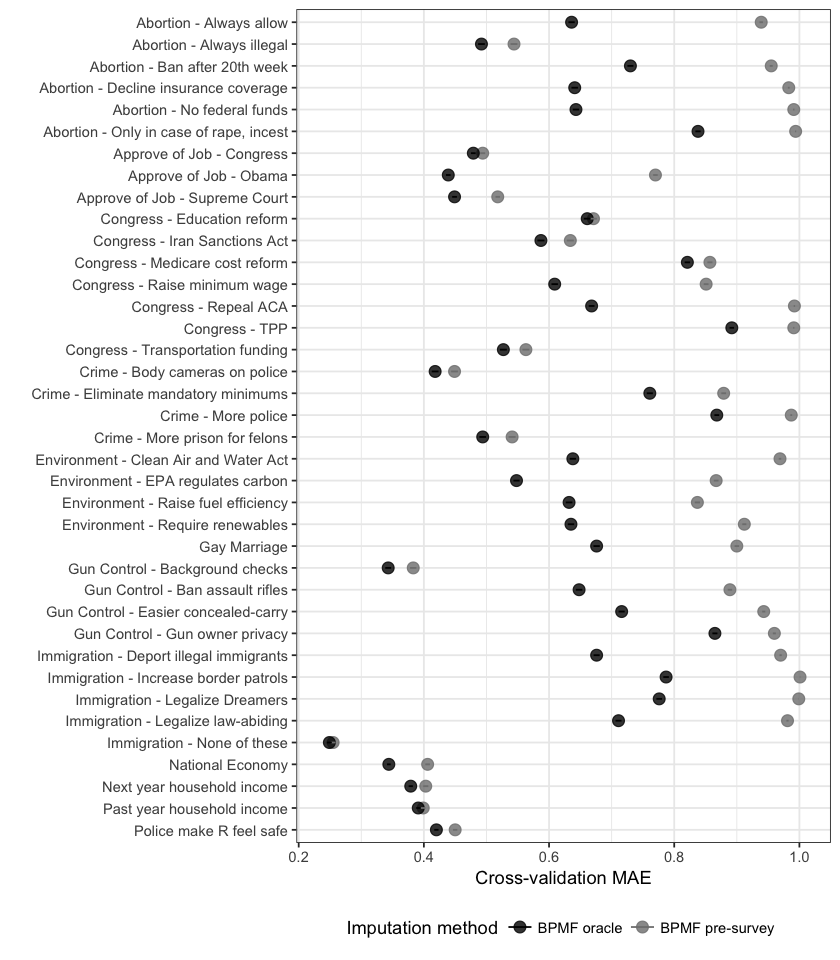

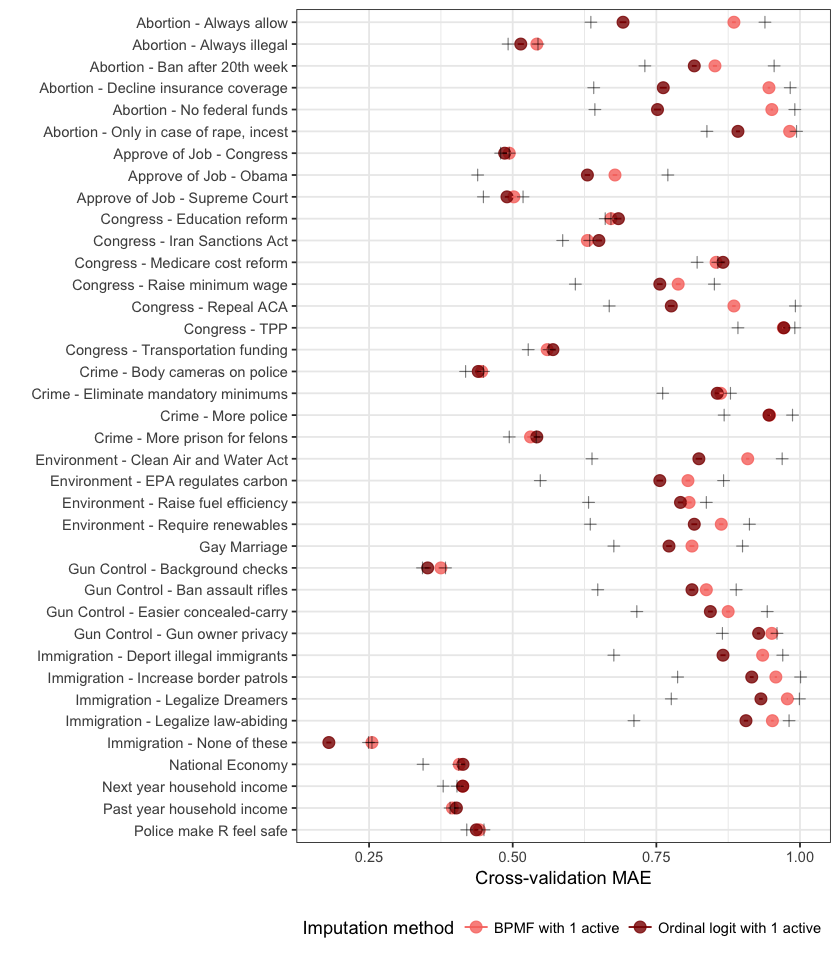

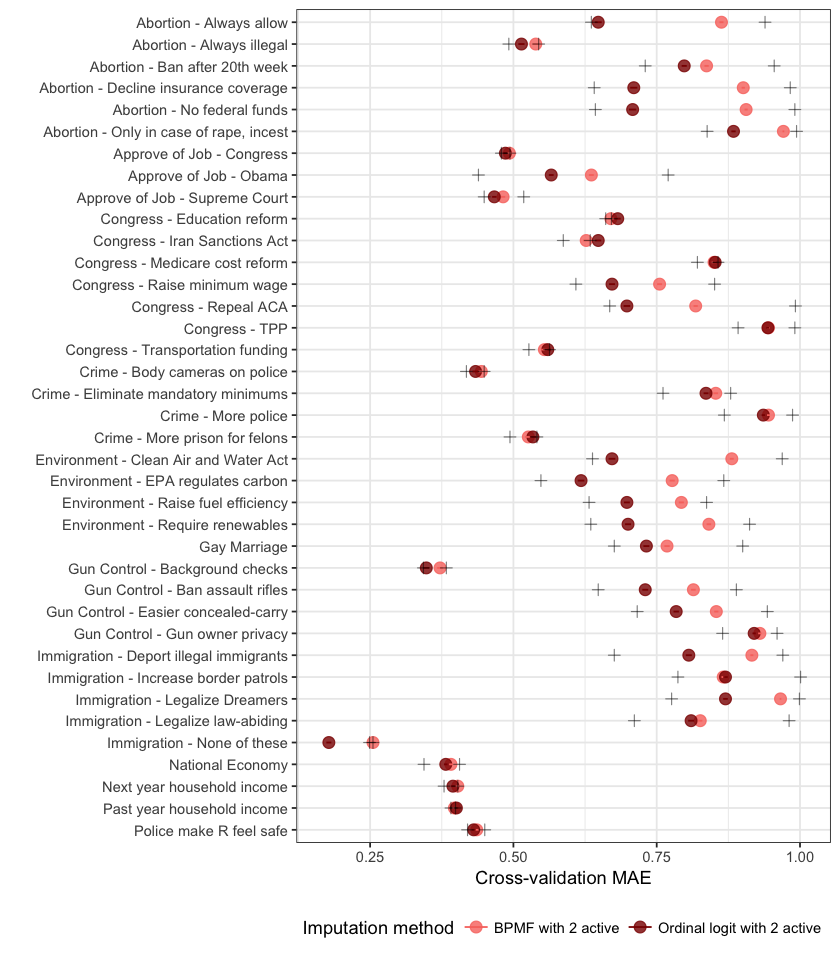

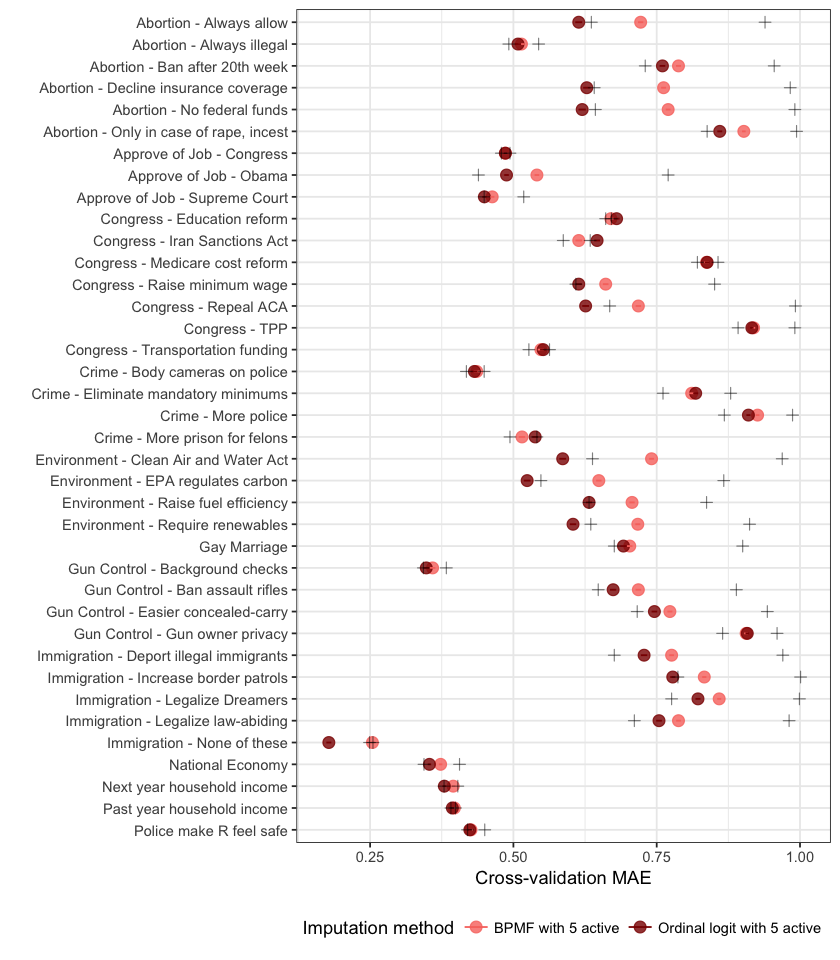

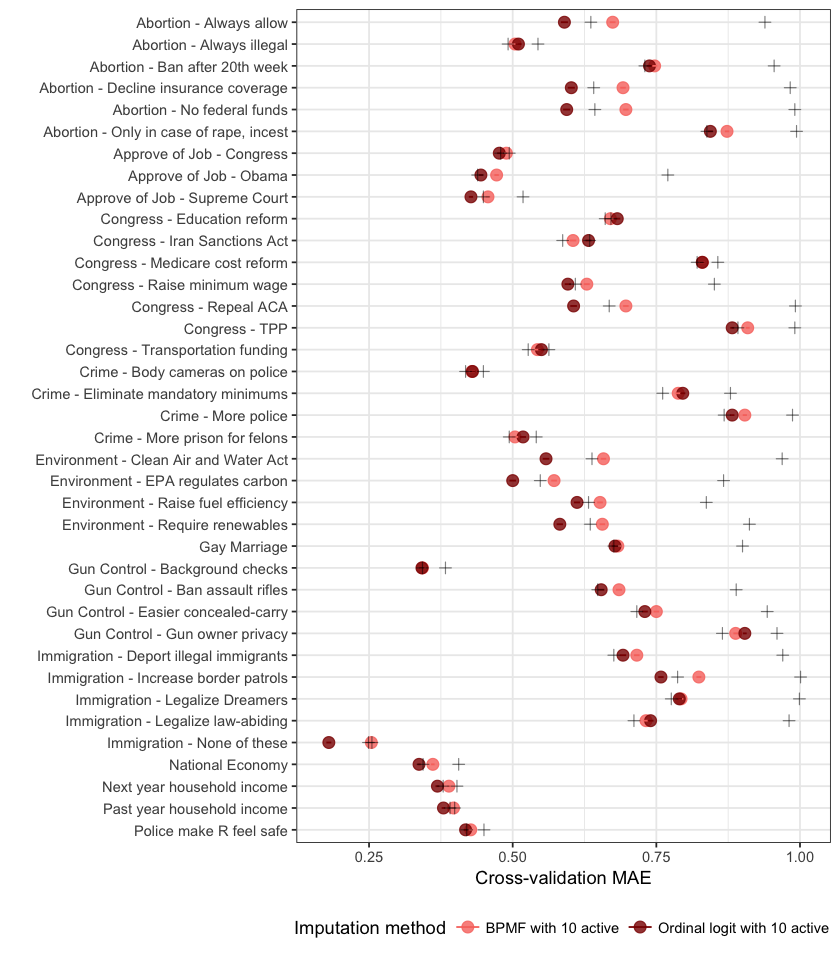

Warning message:
“Column `columns` joining factor and character vector, coercing into character vector”Warning message:
“Column `columns`/`question` joining character vector and factor, coercing into character vector”

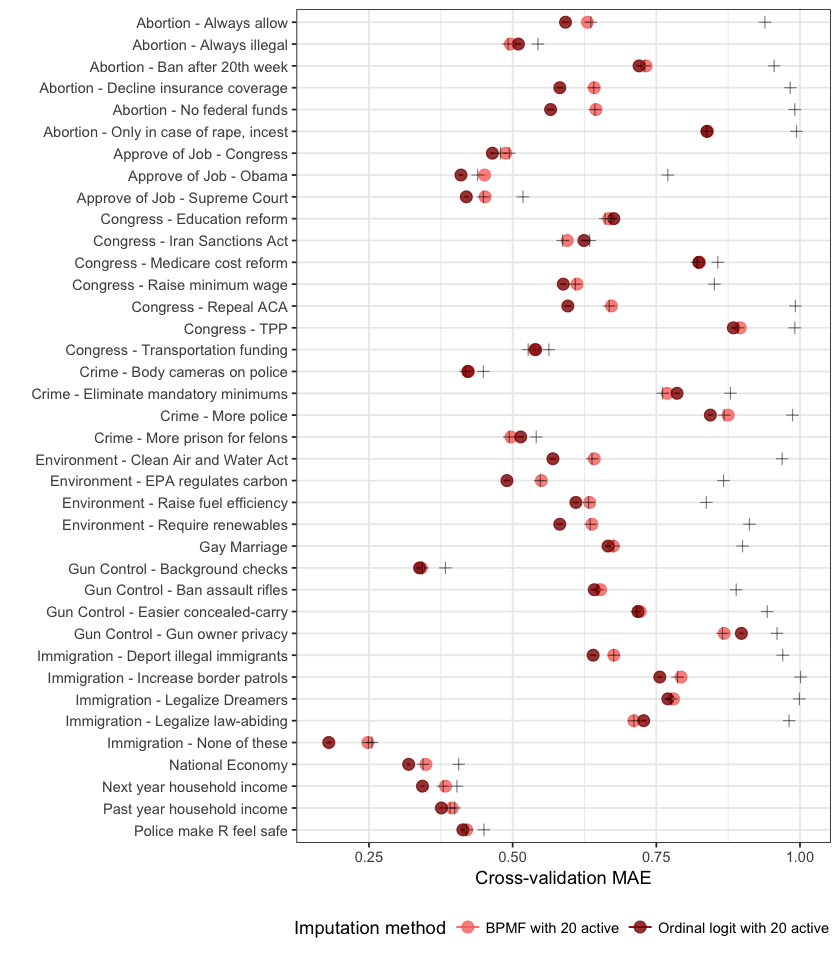

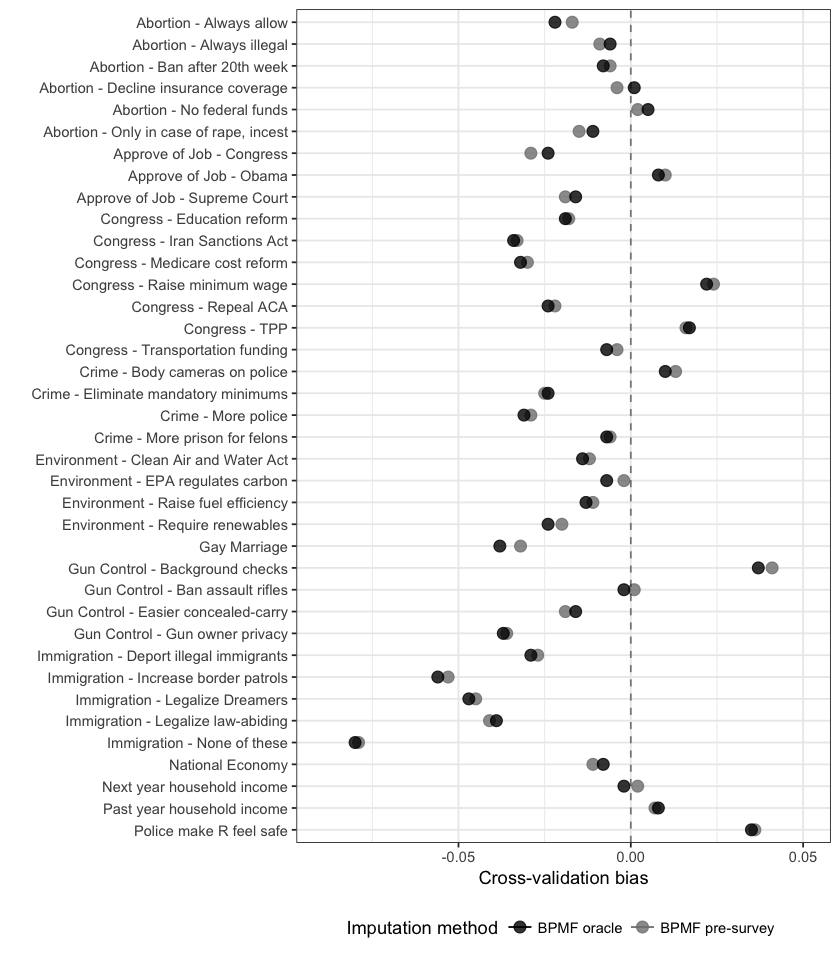

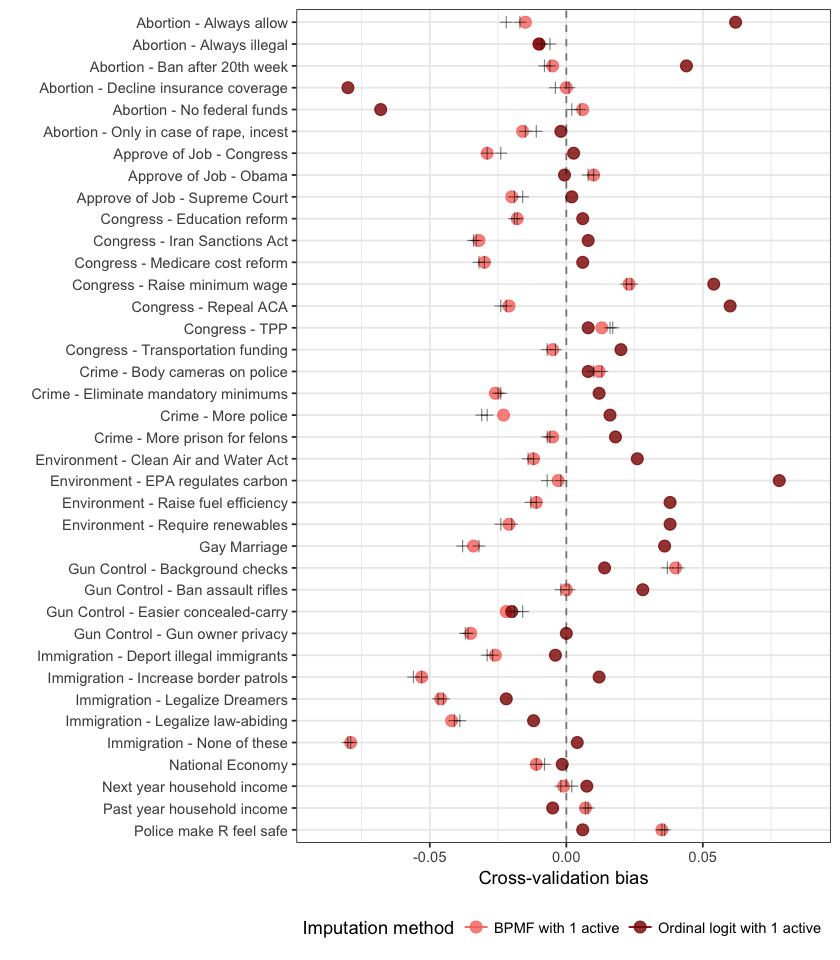

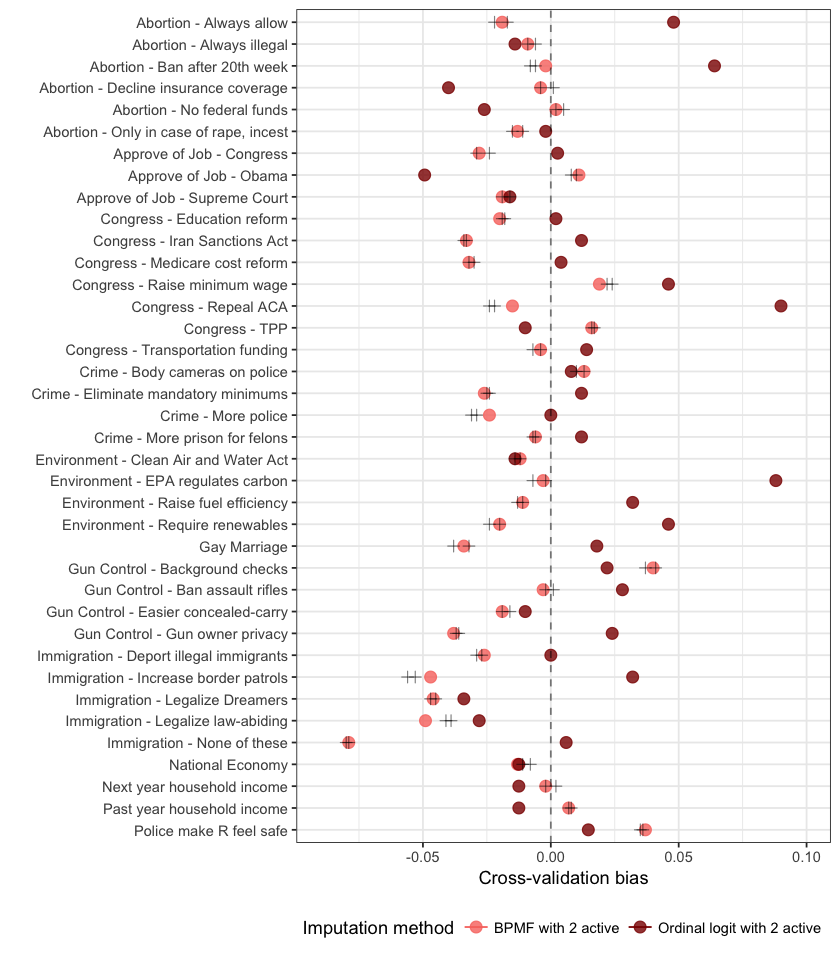

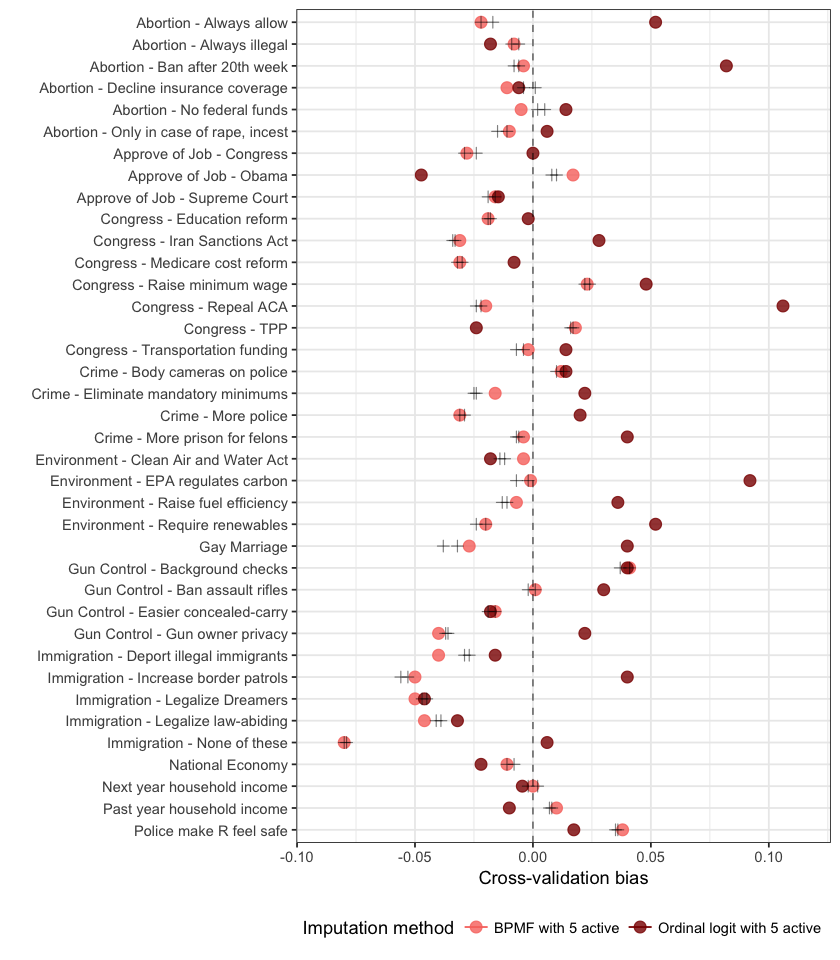

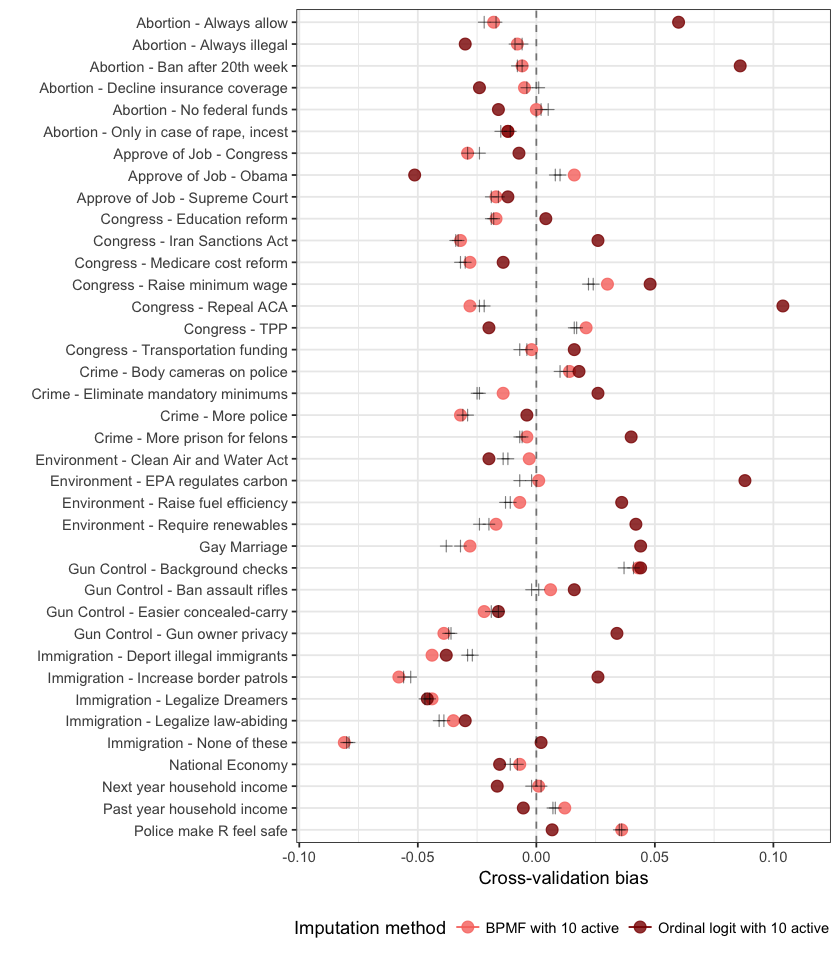

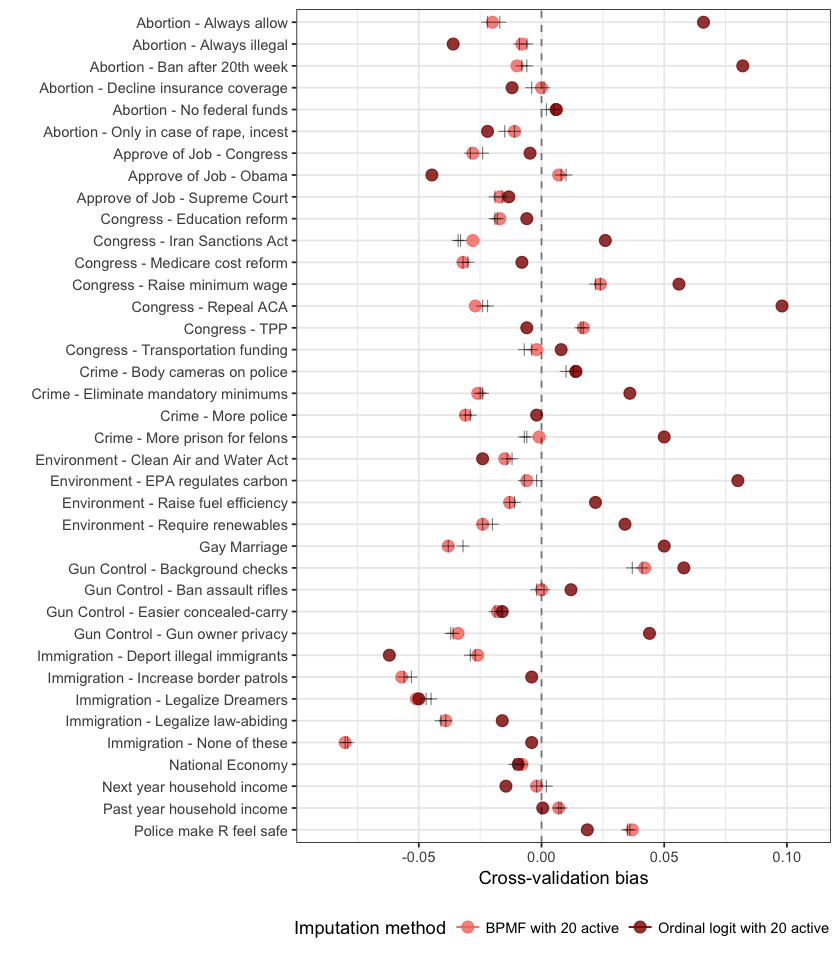

In [11]:
plot_ordlogit_vs_bpmf(y_var='mae', sd_var='sdae', y_var_readable='MAE', question_df=question_df,
                      cur_eval_method = 'kfoldcv', range_by_question = range_by_question)
plot_ordlogit_vs_bpmf(y_var='bias', y_var_readable='bias', question_df=question_df,
                      cur_eval_method = 'kfoldcv', range_by_question = range_by_question)